# 概述
试图只通过EDA和数据可视化来得到一个较好的预测结果。  
  
一般验证特征是否有效，都需要去实际扔进模型里跑一遍看看结果，但是这次的分类问题有个取巧的地方，可以直接通过原始准确率来判断。  
  
原理是：  
分类模型一般用树模型，而树模型的本质一般都是根据特征去不停的划分节点和分枝；  
且最简单的树模型是直接根据准确率去划分的；  
所以只要你构造的特征，可以让准确率提升，那么你的特征就是有效的  
  


比如Titanic train数据及中，原始存活率是0.3838，如果你能挖掘出存活率大于0.3838的，那基本就是有效的。  
所以要做的就是，以0.3838为基准，不停的去挖掘特征，超过这个数值。  
  
最后，可视化和EDA技术本身只是手段，重要的从中提取有效信息。

# 基础处理
处理文本  
缺失值暂不做处理，当做特殊一类

In [20]:
# 导入包
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.preprocessing import LabelEncoder


# 不用print，直接显示结果
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# 显示所有列
pd.set_option('display.max_columns', 600)



In [2]:
# 读取数据
train = pd.read_csv('./Titanic data/train.csv')
test = pd.read_csv('./Titanic data/test.csv')

原始准确率为 0.3838  
Age和Cabin和Embarked有缺失值，Cabin缺失值严重  
Name和Sex和Ticket和Cabin和Embarked是文本型的，需要转成数值

In [3]:
train['Survived'].sum() / train['Survived'].count()

train.info()
train.head()

test.info()
test.head()

0.3838383838383838

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
# 处理文本数据
## Sex 两类，直接转成0-1变量
train['Sex'].value_counts()
train['Sex_num'] = train['Sex'].replace(['male','female'],[0,1])

male      577
female    314
Name: Sex, dtype: int64

In [5]:
## ticket
# 票号可能是随机的，数量和种类过于分散
# 或者有某种规律，但是我们这边暂时挖掘不到
# 我们认为票的费用更重要些，所以删除ticket这个特征
train['Ticket'].value_counts()
train.drop(['Ticket'], axis=1,inplace=True)

347082      7
1601        7
CA. 2343    7
347088      6
CA 2144     6
           ..
113767      1
2697        1
11755       1
349212      1
113050      1
Name: Ticket, Length: 681, dtype: int64

In [6]:
## Cabin
# cabin有147个分类，且每个分类数量其实都不多，猜测这个是每个人/家庭 入住的具体的房间号
# 尝试提取第一个英文字母，再转成数字或onehot
train['Cabin'].value_counts()
train['Cabin_num'] = train['Cabin'].astype(str).str[0]
train['Cabin_num'].value_counts() # 其中n为缺失值

#X_train.groupby(['Cabin'])['Survived'].mean()


G6             4
C23 C25 C27    4
B96 B98        4
F2             3
C22 C26        3
              ..
C95            1
D48            1
D56            1
C85            1
C30            1
Name: Cabin, Length: 147, dtype: int64

n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin_num, dtype: int64

In [7]:
# name
# 提取称呼
train['Name'].value_counts()
train['Title'] = train.Name.str.extract('([A-Za-z]+)\.', expand=False)
train['Title'].value_counts()

# 统一称呼
title_Dict = {}
title_Dict.update(dict.fromkeys(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer'))
title_Dict.update(dict.fromkeys(['Jonkheer', 'Don', 'Sir', 'the Countess', 'Dona', 'Lady'], 'Royalty'))
title_Dict.update(dict.fromkeys(['Mme', 'Ms', 'Mrs'], 'Mrs'))
title_Dict.update(dict.fromkeys(['Mlle', 'Miss'], 'Miss'))
title_Dict.update(dict.fromkeys(['Mr'], 'Mr'))
title_Dict.update(dict.fromkeys(['Master'], 'Master'))

train['Title'] = train['Title'].map(title_Dict)
train['Title'].value_counts() # 最后剩下6类

# 转化为数字
train['Title_num'] = train['Title'].map({'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Officer': 5, 'Royalty': 6})
train['Title_num'].value_counts() 

Dennis, Mr. Samuel                                1
Rothschild, Mrs. Martin (Elizabeth L. Barrett)    1
Fry, Mr. Richard                                  1
Sunderland, Mr. Victor Francis                    1
Moor, Master. Meier                               1
                                                 ..
Sirota, Mr. Maurice                               1
Hansen, Mr. Henry Damsgaard                       1
Hansen, Mr. Claus Peter                           1
Carr, Miss. Helen "Ellen"                         1
Butt, Major. Archibald Willingham                 1
Name: Name, Length: 891, dtype: int64

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Mlle          2
Col           2
Sir           1
Don           1
Countess      1
Capt          1
Ms            1
Lady          1
Mme           1
Jonkheer      1
Name: Title, dtype: int64

Mr         517
Miss       184
Mrs        127
Master      40
Officer     18
Royalty      4
Name: Title, dtype: int64

1.0    517
2.0    184
3.0    127
4.0     40
5.0     18
6.0      4
Name: Title_num, dtype: int64

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
 11  Sex_num      891 non-null    int64  
 12  Cabin_num    891 non-null    object 
 13  Title        890 non-null    object 
 14  Title_num    890 non-null    float64
dtypes: float64(3), int64(6), object(6)
memory usage: 104.5+ KB


# 数据探索-单变量
基准存活率为38.4%
  
PassengerId为唯一值，无效  
除了fare和age算是连续变量；其他都可以归为分类变量。
仅从一些数值分布来看SibSp和Parch还是很有相关性的，0和1占大头。

<AxesSubplot:ylabel='Survived'>

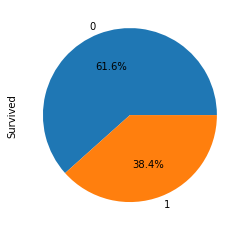

In [14]:
train['Survived'].value_counts().plot.pie(autopct='%1.1f%%')

In [40]:
# 查看其他变量的情况
columns = ['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp','Parch', 'Fare', 'Embarked', 'Cabin_num', 'Title']
for feat in columns:
    print(feat + "'s value:")
    train[feat].value_counts()

PassengerId's value:


891    1
293    1
304    1
303    1
302    1
      ..
591    1
590    1
589    1
588    1
1      1
Name: PassengerId, Length: 891, dtype: int64

Survived's value:


0    549
1    342
Name: Survived, dtype: int64

Pclass's value:


3    491
1    216
2    184
Name: Pclass, dtype: int64

Sex's value:


male      577
female    314
Name: Sex, dtype: int64

Age's value:


24.00    30
22.00    27
18.00    26
19.00    25
30.00    25
         ..
55.50     1
70.50     1
66.00     1
23.50     1
0.42      1
Name: Age, Length: 88, dtype: int64

SibSp's value:


0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

Parch's value:


0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

Fare's value:


8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
8.4583      1
9.8375      1
8.3625      1
14.1083     1
17.4000     1
Name: Fare, Length: 248, dtype: int64

Embarked's value:


S    644
C    168
Q     77
Name: Embarked, dtype: int64

Cabin_num's value:


n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin_num, dtype: int64

Title's value:


Mr         517
Miss       184
Mrs        127
Master      40
Officer     18
Royalty      4
Name: Title, dtype: int64

# 数据探索-多变量交互
上面的单变量只是看个大概，最重要的还是将其他变量和目标变量Survived结合起来看。  
记住基准准确率：38.4%